In [57]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Database connection parameters
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_NAME = os.getenv("POSTGRES_DB", "db")
DB_USER = os.getenv("POSTGRES_USER", "db_user")
DB_PASS = os.getenv("POSTGRES_PASSWORD", "db_password")
DB_PORT = os.getenv("DB_PORT", "5432")

# Connect to the database
def get_db_connection():
    conn = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS,
        port=DB_PORT
    )
    return conn

print("Libraries loaded and DB connection configured.")

Libraries loaded and DB connection configured.


In [58]:
# Load data from all tables (2020-2025)
def load_all_data():
    conn = get_db_connection()
    
    # Generate the UNION ALL query dynamically
    years = range(2020, 2026)
    queries = []
    for year in years:
        queries.append(f"SELECT *, {year} as source_year FROM top_singles_{year}")
    
    full_query = " UNION ALL ".join(queries)
    
    df = pd.read_sql_query(full_query, conn)
    conn.close()
    return df

df = load_all_data()
print(f"Total records loaded: {len(df)}")
df.head()

/var/folders/rr/vnzh8t7108l7nn8z8dj1wrdh0000gn/T/ipykernel_60539/3180399202.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(full_query, conn)


Total records loaded: 61600


,id,classement,artiste,artiste_2,artiste_3,artiste_4,titre,editeur,annee,semaine,producer_1,producer_2,writer_1,writer_2,release_date,sample_type,sample_from,created_at,source_year
0,1,1,GRADUR,HEUSS L'ENFOIRÉ,,,NE REVIENS PAS,CAPITOL MUSIC FRANCE / MILLENIUM,2020,1,Zeg P,None,Gradur,Heuss L’enfoiré,2019-11-22,sample,Blue - Poupie,2025-11-24 17:21:06.210236,2020
1,2,2,HEUSS L'ENFOIRÉ,JUL,,,MOULAGA,MIDI MIDI PRODUCTION/150 PROD,2020,1,Zeg P,DJ Wiils,JuL,Heuss L’enfoiré,2019-12-13,sample,Moulaga - n1kiplugg,2025-11-24 17:21:06.210236,2020
2,3,3,TONES AND I,,,,DANCE MONKEY,WEA / ELEKTRA (NEK),2020,1,Konstantin Kersting,None,Tones and I,None,2019-05-10,sample,2000-2019 mashup | 200 songs from the last 20 ...,2025-11-24 17:21:06.210236,2020
3,4,4,THE WEEKND,,,,BLINDING LIGHTS,DEF JAM RECORDINGS FRANCE / REPUBLIC,2020,1,The Weeknd,Max Martin,The Weeknd,Oscar Holter,2019-11-29,sample,Pulsar City Alarm - Adams & Fleisner,2025-11-24 17:21:06.210236,2020
4,5,5,MAES,,,,DISTANT,CAPITOL MUSIC FRANCE / MILLENIUM,2020,1,HoloMobb,Boumidjal,Ninho,Maes,2019-12-20,None,None,2025-11-24 17:21:06.210236,2020


## 1. Data Overview & Cleaning
Let's check the data types and missing values.

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61600 entries, 0 to 61599
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            61600 non-null  int64         
 1   classement    61600 non-null  int64         
 2   artiste       61600 non-null  object        
 3   artiste_2     61600 non-null  object        
 4   artiste_3     61600 non-null  object        
 5   artiste_4     61600 non-null  object        
 6   titre         61600 non-null  object        
 7   editeur       61600 non-null  object        
 8   annee         61600 non-null  int64         
 9   semaine       61600 non-null  int64         
 10  producer_1    58334 non-null  object        
 11  producer_2    31174 non-null  object        
 12  writer_1      58838 non-null  object        
 13  writer_2      38308 non-null  object        
 14  release_date  59362 non-null  object        
 15  sample_type   24906 non-null  object

In [60]:
# Basic Statistics
print(f"Unique Artists: {df['artiste'].nunique()}")
print(f"Unique Songs: {df['titre'].nunique()}")
print(f"Date Range: {df['source_year'].min()} - {df['source_year'].max()}")

Unique Artists: 1096
Unique Songs: 5916
Date Range: 2020 - 2025


## 2. Top Artists Analysis
Who are the artists with the most cumulative weeks in the Top 50?

/var/folders/rr/vnzh8t7108l7nn8z8dj1wrdh0000gn/T/ipykernel_60539/273634570.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette="viridis", ax=ax)


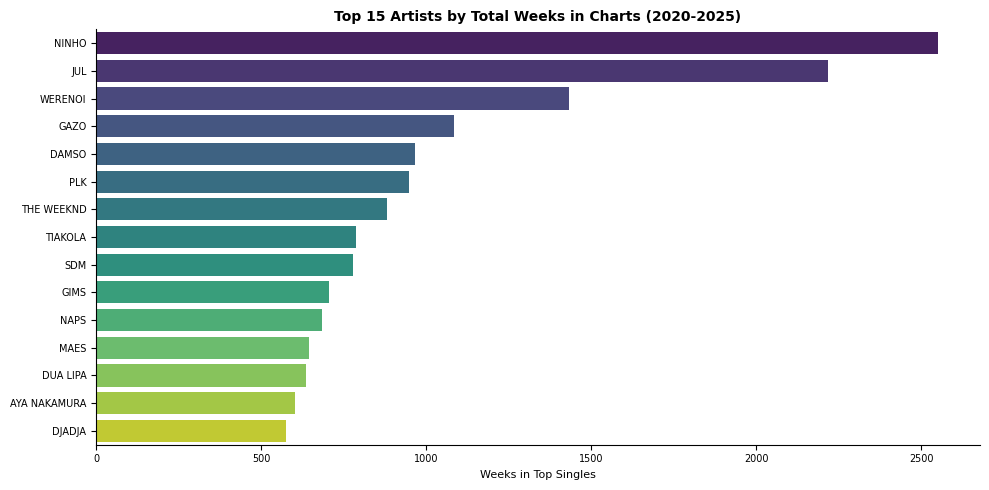

In [61]:
# Count occurrences of each artist
top_artists = df['artiste'].value_counts().head(15)

# Modern style
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=top_artists.values, y=top_artists.index, palette="viridis", ax=ax)
ax.set_title("Top 15 Artists by Total Weeks in Charts (2020-2025)", fontsize=10, fontweight='bold')
ax.set_xlabel("Weeks in Top Singles", fontsize=8)
ax.set_ylabel("")
ax.tick_params(axis='both', labelsize=7)
sns.despine()
plt.tight_layout()
plt.show()

## 3. Song Longevity
Which songs stayed in the charts the longest?

/var/folders/rr/vnzh8t7108l7nn8z8dj1wrdh0000gn/T/ipykernel_60539/2504724267.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weeks', y='display', data=top_songs, palette="magma")


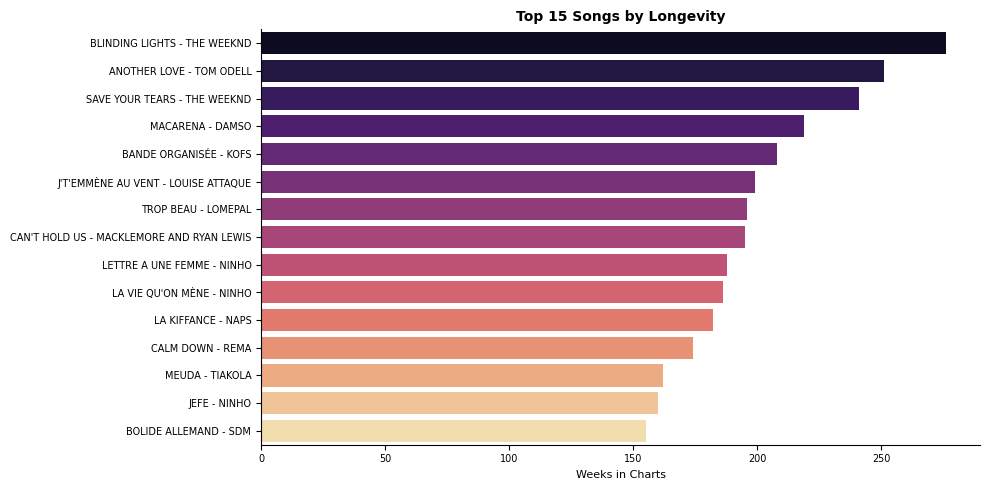

In [62]:
# Group by title and artist to count weeks
song_longevity = df.groupby(['titre', 'artiste']).size().reset_index(name='weeks')
top_songs = song_longevity.sort_values(by='weeks', ascending=False).head(15)

# Combine title and artist for display
top_songs['display'] = top_songs['titre'] + " - " + top_songs['artiste']

plt.figure(figsize=(10, 5))
sns.barplot(x='weeks', y='display', data=top_songs, palette="magma")
plt.title("Top 15 Songs by Longevity", fontsize=10, fontweight='bold')
plt.xlabel("Weeks in Charts", fontsize=8)
plt.ylabel("")
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
plt.tight_layout()
plt.show()

## 4. Producer Analysis
Since we have producer data (`producer_1`, `producer_2`), let's see who dominates the production side.

/var/folders/rr/vnzh8t7108l7nn8z8dj1wrdh0000gn/T/ipykernel_60539/4013564860.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_producers.values, y=top_producers.index, palette="rocket", ax=ax)


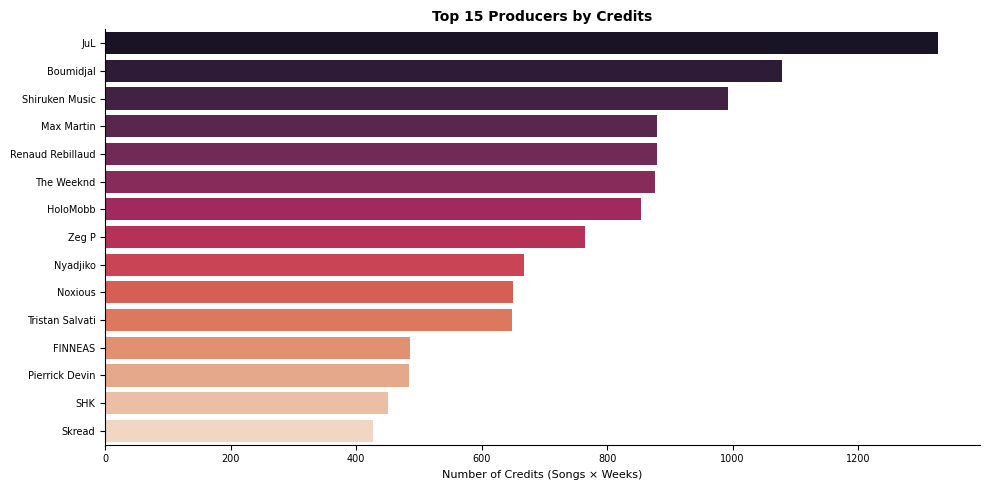

In [63]:
# Combine producer columns
producers = pd.concat([df['producer_1'], df['producer_2']]).dropna()
producers = producers[producers != '']

top_producers = producers.value_counts().head(15)

# Modern style
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=top_producers.values, y=top_producers.index, palette="rocket", ax=ax)
ax.set_title("Top 15 Producers by Credits", fontsize=10, fontweight='bold')
ax.set_xlabel("Number of Credits (Songs × Weeks)", fontsize=8)
ax.set_ylabel("")
ax.tick_params(axis='both', labelsize=7)
sns.despine()
plt.tight_layout()
plt.show()

## 5. Weekly Trends for a Top Artist
Let's pick the top artist (e.g., Jul) and see their presence over time.

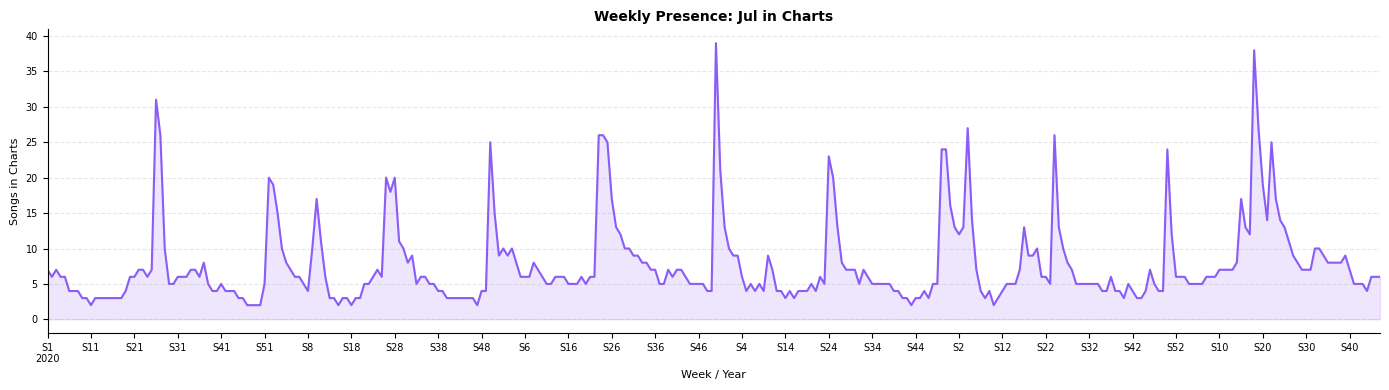

In [64]:
target_artist = "Jul"
artist_data = df[df['artiste'].str.contains(target_artist, case=False, na=False)].copy()

# Create a proper date-like index for plotting
artist_data['year'] = artist_data['source_year']
artist_data['week'] = artist_data['semaine']
artist_data = artist_data.sort_values(['year', 'week'])

# Count songs per week
songs_per_week = artist_data.groupby(['year', 'week']).size().reset_index(name='count')

# Create x-axis labels: "S{week}\n{year}" but only show year when it changes
x_labels = []
prev_year = None
for _, row in songs_per_week.iterrows():
    if row['year'] != prev_year:
        x_labels.append(f"S{int(row['week'])}\n{int(row['year'])}")
        prev_year = row['year']
    else:
        x_labels.append(f"S{int(row['week'])}")

# Modern color palette
line_color = '#8B5CF6'  # Violet

fig, ax = plt.subplots(figsize=(14, 4))

# Plot with fill under the curve
ax.plot(range(len(songs_per_week)), songs_per_week['count'], color=line_color, linewidth=1.5)
ax.fill_between(range(len(songs_per_week)), songs_per_week['count'], alpha=0.15, color=line_color)

ax.set_title(f"Weekly Presence: {target_artist} in Charts", fontsize=10, fontweight='bold')
ax.set_xlabel("Week / Year", fontsize=8)
ax.set_ylabel("Songs in Charts", fontsize=8)

# Reduce x-tick density: show every 10th label
tick_step = 10
ax.set_xticks(range(0, len(x_labels), tick_step))
ax.set_xticklabels([x_labels[i] for i in range(0, len(x_labels), tick_step)], fontsize=7, rotation=0)
ax.tick_params(axis='y', labelsize=7)

# Light grid on y-axis only
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_xlim(0, len(songs_per_week) - 1)
sns.despine()

plt.tight_layout()
plt.show()

## 6. Distribution of Success: Artists vs Producers
How is the number of songs distributed? Do most artists have only 1 hit while a few have many? How does this compare to producers?

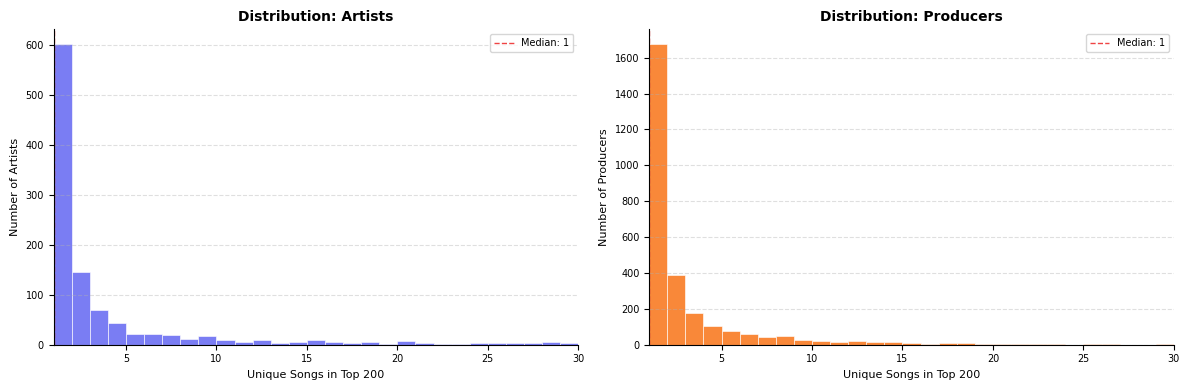

Artists  → Median: 1 | Max: 343 (JUL)
Producers → Median: 1 | Max: 139 (JuL)


In [65]:
# Calculate unique songs per Artist
artist_song_counts = df.groupby('artiste')['titre'].nunique()

# Calculate unique songs per Producer
prod1 = df[['titre', 'producer_1']].rename(columns={'producer_1': 'producer'})
prod2 = df[['titre', 'producer_2']].rename(columns={'producer_2': 'producer'})
all_producers = pd.concat([prod1, prod2]).dropna()
all_producers = all_producers[~all_producers['producer'].isin(['', 'Unknown', 'NaN'])]
producer_song_counts = all_producers.groupby('producer')['titre'].nunique()

# Modern color palette
artist_color = '#6366F1'   # Indigo
producer_color = '#F97316' # Orange

# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Artists Distribution
axes[0].hist(artist_song_counts, bins=range(1, 40), alpha=0.85, color=artist_color, edgecolor='white', linewidth=0.5)
axes[0].set_title("Distribution: Artists", fontsize=10, fontweight='bold')
axes[0].set_xlabel("Unique Songs in Top 200", fontsize=8)
axes[0].set_ylabel("Number of Artists", fontsize=8)
axes[0].tick_params(axis='both', labelsize=7)
axes[0].set_xlim(1, 30)
axes[0].grid(axis='y', linestyle='--', alpha=0.4)
axes[0].axvline(artist_song_counts.median(), color='#EF4444', linestyle='--', linewidth=1, label=f'Median: {artist_song_counts.median():.0f}')
axes[0].legend(fontsize=7)
sns.despine(ax=axes[0])

# Producers Distribution
axes[1].hist(producer_song_counts, bins=range(1, 40), alpha=0.85, color=producer_color, edgecolor='white', linewidth=0.5)
axes[1].set_title("Distribution: Producers", fontsize=10, fontweight='bold')
axes[1].set_xlabel("Unique Songs in Top 200", fontsize=8)
axes[1].set_ylabel("Number of Producers", fontsize=8)
axes[1].tick_params(axis='both', labelsize=7)
axes[1].set_xlim(1, 30)
axes[1].grid(axis='y', linestyle='--', alpha=0.4)
axes[1].axvline(producer_song_counts.median(), color='#EF4444', linestyle='--', linewidth=1, label=f'Median: {producer_song_counts.median():.0f}')
axes[1].legend(fontsize=7)
sns.despine(ax=axes[1])

plt.tight_layout()
plt.show()

# Print some stats
print(f"Artists  → Median: {artist_song_counts.median():.0f} | Max: {artist_song_counts.max()} ({artist_song_counts.idxmax()})")
print(f"Producers → Median: {producer_song_counts.median():.0f} | Max: {producer_song_counts.max()} ({producer_song_counts.idxmax()})")